# Prepare Data

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder



#from xgboost import XGBClassifier
import lightgbm as lgb
import xgboost as xgb



In [12]:
import os
os.getcwd()

'/Users/mfilipav/Desktop/bucher/SmartCleanCityHackZurich19'

In [270]:
df = pd.read_csv("./data/2019-09-27-basel-measures-FEAT-TempPrecip.csv", sep=',')

In [271]:
df.head()

,Unnamed: 0,osm_id,cci_id,date,place_name,place_type,cci,cci_p,hour,weekday,month,month_german,weekday_german,daytime,t_mean_2m_24h:C,precip_24h:mm
0,0,1175332462,287,2019-04-01 8:40:49,Leimgrubenweg,bus_stop,3.20000,3.20000,8,0,4,April,Montag,morning,11.4,0.0
1,1,25149740,86_9668,2019-04-01 8:40:53,Leimgrubenweg,secondary,3.35764,3.35764,8,0,4,April,Montag,morning,11.4,0.0
2,2,117485263,86_11641,2019-04-01 8:40:53,Reinacherstrasse,primary,3.35764,3.35764,8,0,4,April,Montag,morning,11.4,0.0
3,3,2621172927,287,2019-04-01 8:40:57,Leimgrubenweg,bus_stop,3.19757,3.19757,8,0,4,April,Montag,morning,11.4,0.0
4,4,148833576,86_12436,2019-04-01 8:42:11,Dornacherstrasse,secondary,5.00000,5.00000,8,0,4,April,Montag,morning,11.4,0.0


## Give `place_name` and `place_type` to predictions datatset from `osm_id` and	`cci_id`

In [175]:
df_pred = pd.read_csv("./data/2019-09-27-basel-measures-prediction-cleaned.csv", sep=";") 


In [176]:
df_pred.head()

,osm_id,cci_id,date
0,172611027,86_12812,2019-06-25 6:25:49
1,3828924874,260,2019-06-25 6:26:22
2,23913163,86_9255,2019-06-25 6:26:26
3,23913163,86_17476,2019-06-25 6:26:26
4,144481239,86_12223,2019-06-25 6:27:21


In [177]:
dummy = df[['osm_id', 'cci_id', 'place_name','place_type', ]].drop_duplicates()

dummy.head()

,osm_id,cci_id,place_name,place_type
0,1175332462,287,Leimgrubenweg,bus_stop
1,25149740,86_9668,Leimgrubenweg,secondary
2,117485263,86_11641,Reinacherstrasse,primary
3,2621172927,287,Leimgrubenweg,bus_stop
4,148833576,86_12436,Dornacherstrasse,secondary


In [178]:
df_pred = pd.merge(df_pred, dummy,  how='left', on=['osm_id','cci_id'])
df_pred.head()

,osm_id,cci_id,date,place_name,place_type
0,172611027,86_12812,2019-06-25 6:25:49,Klingelbergstrasse,residential
1,3828924874,260,2019-06-25 6:26:22,Metzerstrasse,bus_stop
2,23913163,86_9255,2019-06-25 6:26:26,Metzerstrasse,residential
3,23913163,86_17476,2019-06-25 6:26:26,Metzerstrasse,residential
4,144481239,86_12223,2019-06-25 6:27:21,Metzerstrasse,residential


## Give `temp` and `precipitation` to predictions dataset by utilizing `date`

In [179]:
mt = pd.read_csv("./data/180_days_meanT_24hrPrecip.csv", sep=";")
mt["date_short"] = mt.validdate.apply(lambda x: x.split('T')[0])
mt.head()

,validdate,t_mean_2m_24h:C,precip_24h:mm,date_short
0,2019-04-01T07:00:00Z,11.4,0.00,2019-04-01
1,2019-04-02T07:00:00Z,11.2,0.00,2019-04-02
2,2019-04-03T07:00:00Z,13.3,3.90,2019-04-03
3,2019-04-04T07:00:00Z,5.7,6.90,2019-04-04
4,2019-04-05T07:00:00Z,2.9,2.21,2019-04-05


In [180]:
df_pred["date_short"] = df_pred.date.apply(lambda x: x.split(" ")[0])

In [181]:
df_pred = pd.merge(df_pred, mt, how="left", on="date_short")
df_pred.head()

,osm_id,cci_id,date,place_name,place_type,date_short,validdate,t_mean_2m_24h:C,precip_24h:mm
0,172611027,86_12812,2019-06-25 6:25:49,Klingelbergstrasse,residential,2019-06-25,2019-06-25T07:00:00Z,24.7,0.0
1,3828924874,260,2019-06-25 6:26:22,Metzerstrasse,bus_stop,2019-06-25,2019-06-25T07:00:00Z,24.7,0.0
2,23913163,86_9255,2019-06-25 6:26:26,Metzerstrasse,residential,2019-06-25,2019-06-25T07:00:00Z,24.7,0.0
3,23913163,86_17476,2019-06-25 6:26:26,Metzerstrasse,residential,2019-06-25,2019-06-25T07:00:00Z,24.7,0.0
4,144481239,86_12223,2019-06-25 6:27:21,Metzerstrasse,residential,2019-06-25,2019-06-25T07:00:00Z,24.7,0.0


In [195]:
df_pred.head()

,osm_id,cci_id,date,place_name,place_type,date_short,validdate,t_mean_2m_24h:C,precip_24h:mm
0,172611027,86_12812,2019-06-25 6:25:49,Klingelbergstrasse,residential,2019-06-25,2019-06-25T07:00:00Z,24.7,0.0
1,3828924874,260,2019-06-25 6:26:22,Metzerstrasse,bus_stop,2019-06-25,2019-06-25T07:00:00Z,24.7,0.0
2,23913163,86_9255,2019-06-25 6:26:26,Metzerstrasse,residential,2019-06-25,2019-06-25T07:00:00Z,24.7,0.0
3,23913163,86_17476,2019-06-25 6:26:26,Metzerstrasse,residential,2019-06-25,2019-06-25T07:00:00Z,24.7,0.0
4,144481239,86_12223,2019-06-25 6:27:21,Metzerstrasse,residential,2019-06-25,2019-06-25T07:00:00Z,24.7,0.0


In [196]:
df_pred.to_csv("./data/2019-09-27-basel-measures-prediction-cleaned-TempPrecip.csv")

## Add Twitter features

In [213]:
tw = pd.read_csv("./data/twitter_day_features.csv", sep=",")

tw['date_short'] = tw['day_date']
tw = tw[['date_short', 'tw_place_mentions']]

In [223]:
tw_t = pd.read_csv("./data/twitter_day_features-TEST.csv", sep=",")

tw_t['date_short'] = tw_t['day_date']
tw_t = tw_t[['date_short', 'tw_place_mentions']]

In [224]:
tw_t.head()

,date_short,tw_place_mentions
0,2019-06-25,NaN
1,2019-06-26,theater
2,2019-06-27,theater
3,2019-06-28,"st. jakob, theater"
4,2019-08-28,wiesenstrasse


In [225]:
tw.head(5)

,date_short,tw_place_mentions
0,2019-06-25,NaN
1,2019-06-26,theater
2,2019-06-27,theater
3,2019-06-28,"st. jakob, theater"
4,2019-08-28,wiesenstrasse


In [215]:
df.head()

,Unnamed: 0,osm_id,cci_id,date,place_name,place_type,cci,cci_p,hour,weekday,month,month_german,weekday_german,daytime,t_mean_2m_24h:C,precip_24h:mm,place_type_enc,daytime_enc,place_name_enc,date_short
0,0,1175332462,287,2019-04-01 8:40:49,Leimgrubenweg,bus_stop,3.20000,3.20000,8,0,4,April,Montag,morning,11.4,0.0,0,2,163,2019-04-01
1,1,25149740,86_9668,2019-04-01 8:40:53,Leimgrubenweg,secondary,3.35764,3.35764,8,0,4,April,Montag,morning,11.4,0.0,11,2,163,2019-04-01
2,2,117485263,86_11641,2019-04-01 8:40:53,Reinacherstrasse,primary,3.35764,3.35764,8,0,4,April,Montag,morning,11.4,0.0,8,2,210,2019-04-01
3,3,2621172927,287,2019-04-01 8:40:57,Leimgrubenweg,bus_stop,3.19757,3.19757,8,0,4,April,Montag,morning,11.4,0.0,0,2,163,2019-04-01
4,4,148833576,86_12436,2019-04-01 8:42:11,Dornacherstrasse,secondary,5.00000,5.00000,8,0,4,April,Montag,morning,11.4,0.0,11,2,65,2019-04-01


In [218]:
df["date_short"] = df.date.apply(lambda x: x.split(" ")[0])
len(df)

58242

In [219]:
df = pd.merge(df, tw, how="left", on="date_short")


In [220]:
df.head()

,Unnamed: 0,osm_id,cci_id,date,place_name,place_type,cci,cci_p,hour,weekday,...,month_german,weekday_german,daytime,t_mean_2m_24h:C,precip_24h:mm,place_type_enc,daytime_enc,place_name_enc,date_short,tw_place_mentions
0,0,1175332462,287,2019-04-01 8:40:49,Leimgrubenweg,bus_stop,3.20000,3.20000,8,0,...,April,Montag,morning,11.4,0.0,0,2,163,2019-04-01,NaN
1,1,25149740,86_9668,2019-04-01 8:40:53,Leimgrubenweg,secondary,3.35764,3.35764,8,0,...,April,Montag,morning,11.4,0.0,11,2,163,2019-04-01,NaN
2,2,117485263,86_11641,2019-04-01 8:40:53,Reinacherstrasse,primary,3.35764,3.35764,8,0,...,April,Montag,morning,11.4,0.0,8,2,210,2019-04-01,NaN
3,3,2621172927,287,2019-04-01 8:40:57,Leimgrubenweg,bus_stop,3.19757,3.19757,8,0,...,April,Montag,morning,11.4,0.0,0,2,163,2019-04-01,NaN
4,4,148833576,86_12436,2019-04-01 8:42:11,Dornacherstrasse,secondary,5.00000,5.00000,8,0,...,April,Montag,morning,11.4,0.0,11,2,65,2019-04-01,NaN


## Add Twitter to PREDICTIONS

In [227]:
df_pred["date_short"] = df_pred.date.apply(lambda x: x.split(" ")[0])
len(df)
df_pred = pd.merge(df_pred, tw_t, how="left", on="date_short")
len(df_pred)

7292

In [228]:
df_pred.head()

,osm_id,cci_id,date,place_name,place_type,date_short,validdate,t_mean_2m_24h:C,precip_24h:mm,tw_place_mentions
0,172611027,86_12812,2019-06-25 6:25:49,Klingelbergstrasse,residential,2019-06-25,2019-06-25T07:00:00Z,24.7,0.0,NaN
1,3828924874,260,2019-06-25 6:26:22,Metzerstrasse,bus_stop,2019-06-25,2019-06-25T07:00:00Z,24.7,0.0,NaN
2,23913163,86_9255,2019-06-25 6:26:26,Metzerstrasse,residential,2019-06-25,2019-06-25T07:00:00Z,24.7,0.0,NaN
3,23913163,86_17476,2019-06-25 6:26:26,Metzerstrasse,residential,2019-06-25,2019-06-25T07:00:00Z,24.7,0.0,NaN
4,144481239,86_12223,2019-06-25 6:27:21,Metzerstrasse,residential,2019-06-25,2019-06-25T07:00:00Z,24.7,0.0,NaN


In [229]:
df_pred.to_csv("./data/2019-09-27-basel-measures-prediction-cleaned-TempPrecip-Twitter.csv")

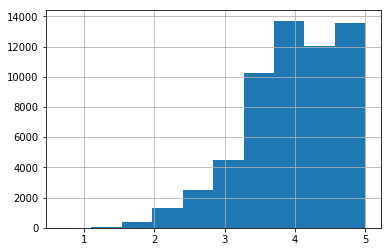

In [129]:
df.cci.hist()

In [17]:
df.head()

,Unnamed: 0,osm_id,cci_id,date,place_name,place_type,cci,cci_p,hour,weekday,month,month_german,weekday_german,daytime,t_mean_2m_24h:C,precip_24h:mm
0,0,1175332462,287,2019-04-01 8:40:49,Leimgrubenweg,bus_stop,3.20000,3.20000,8,0,4,April,Montag,morning,11.4,0.0
1,1,25149740,86_9668,2019-04-01 8:40:53,Leimgrubenweg,secondary,3.35764,3.35764,8,0,4,April,Montag,morning,11.4,0.0
2,2,117485263,86_11641,2019-04-01 8:40:53,Reinacherstrasse,primary,3.35764,3.35764,8,0,4,April,Montag,morning,11.4,0.0
3,3,2621172927,287,2019-04-01 8:40:57,Leimgrubenweg,bus_stop,3.19757,3.19757,8,0,4,April,Montag,morning,11.4,0.0
4,4,148833576,86_12436,2019-04-01 8:42:11,Dornacherstrasse,secondary,5.00000,5.00000,8,0,4,April,Montag,morning,11.4,0.0


In [262]:
df.head()

,Unnamed: 0,osm_id,cci_id,date,place_name,place_type,cci,cci_p,hour,weekday,month,month_german,weekday_german,daytime,t_mean_2m_24h:C,precip_24h:mm
0,0,1175332462,287,2019-04-01 8:40:49,Leimgrubenweg,bus_stop,3.20000,3.20000,8,0,4,April,Montag,morning,11.4,0.0
1,1,25149740,86_9668,2019-04-01 8:40:53,Leimgrubenweg,secondary,3.35764,3.35764,8,0,4,April,Montag,morning,11.4,0.0
2,2,117485263,86_11641,2019-04-01 8:40:53,Reinacherstrasse,primary,3.35764,3.35764,8,0,4,April,Montag,morning,11.4,0.0
3,3,2621172927,287,2019-04-01 8:40:57,Leimgrubenweg,bus_stop,3.19757,3.19757,8,0,4,April,Montag,morning,11.4,0.0
4,4,148833576,86_12436,2019-04-01 8:42:11,Dornacherstrasse,secondary,5.00000,5.00000,8,0,4,April,Montag,morning,11.4,0.0


# Encode categorical variables `place name`, `place type` and `daytime` as `int` nominal labels

In [264]:
df.head()

,Unnamed: 0,osm_id,cci_id,date,place_name,place_type,cci,cci_p,hour,weekday,month,month_german,weekday_german,daytime,t_mean_2m_24h:C,precip_24h:mm
0,0,1175332462,287,2019-04-01 8:40:49,Leimgrubenweg,bus_stop,3.20000,3.20000,8,0,4,April,Montag,morning,11.4,0.0
1,1,25149740,86_9668,2019-04-01 8:40:53,Leimgrubenweg,secondary,3.35764,3.35764,8,0,4,April,Montag,morning,11.4,0.0
2,2,117485263,86_11641,2019-04-01 8:40:53,Reinacherstrasse,primary,3.35764,3.35764,8,0,4,April,Montag,morning,11.4,0.0
3,3,2621172927,287,2019-04-01 8:40:57,Leimgrubenweg,bus_stop,3.19757,3.19757,8,0,4,April,Montag,morning,11.4,0.0
4,4,148833576,86_12436,2019-04-01 8:42:11,Dornacherstrasse,secondary,5.00000,5.00000,8,0,4,April,Montag,morning,11.4,0.0


In [256]:
label_encoder = LabelEncoder()

label_encoder = label_encoder.fit(df.place_type)
place_type_enc = label_encoder.transform(df.place_type)

In [257]:
label_encoder = LabelEncoder()

label_encoder2 = label_encoder.fit(df.daytime)
daytime_enc = label_encoder2.transform(df.daytime)

In [273]:
label_encoder = LabelEncoder()

label_encoder3 = label_encoder.fit(df.place_name)
place_name_enc = label_encoder3.transform(df.place_name)


In [ ]:
label_encoder.fit(df.tw_place_mentions)

In [248]:
label_encoder.fit(df.tw_place_mentions[58230:58241, ])

LabelEncoder()

In [255]:
df.tw_place_mentions.unique()

array([nan, 'horburgstrasse', 'bundesplatz, horburgstrasse',
       'bundesplatz', 'klybeckstrasse', 'wasgenring',
       'wasgenring, erlenmatt', 'theater, erlenmatt', 'aeschenplatz',
       'hegenheimermattweg, bachgraben, breite',
       'centralbahnplatz, nauenstrasse, morgartenring, mühlenberg',
       'nauenstrasse, mühlenberg, morgartenring, marktplatz',
       'redingstrasse, marktplatz, morgartenring, nauenstrasse, mühlenberg',
       'redingstrasse, marktplatz', 'redingstrasse',
       'centralbahnplatz, zwinglihaus, kannenfeldplatz',
       'centralbahnplatz, zwinglihaus, schützenmattstrasse',
       'centralbahnplatz, schützenmattstrasse', 'schützenmattstrasse',
       'neubad, kleinhüningen',
       'theater, kleinhüningen, luzernerring, bruderholzstrasse, neubad',
       'theater, gundeldingerstrasse, iwb, luzernerring, kleinhüningen, neubad, bruderholzstrasse, reinacherstrasse',
       'wielandplatz, schützenhaus, brennerstrasse', 'eisengasse',
       'centralbahnplatz, 

In [249]:
label_encoder = LabelEncoder()

label_encoder4 = label_encoder.fit(df.tw_place_mentions)
tw_place_mentions_enc = label_encoder4.transform(df.tw_place_mentions)

TypeError: '<' not supported between instances of 'str' and 'float'

In [191]:
len(place_type_enc)

58242

In [274]:
place_type_enc = label_encoder.transform(df.place_type)
daytime_enc = label_encoder2.transform(df.daytime)
place_name_enc = label_encoder3.transform(df.place_name)

ValueError: y contains previously unseen labels: 'bus_stop'

In [259]:
df['place_type_enc'] = place_type_enc
df['daytime_enc'] = daytime_enc
df['place_name_enc'] = place_name_enc
#df['tw_place_mentions_enc'] = tw_place_mentions_enc

In [194]:
df.head()

,Unnamed: 0,osm_id,cci_id,date,place_name,place_type,cci,cci_p,hour,weekday,month,month_german,weekday_german,daytime,t_mean_2m_24h:C,precip_24h:mm,place_type_enc,daytime_enc,place_name_enc
0,0,1175332462,287,2019-04-01 8:40:49,Leimgrubenweg,bus_stop,3.20000,3.20000,8,0,4,April,Montag,morning,11.4,0.0,0,2,163
1,1,25149740,86_9668,2019-04-01 8:40:53,Leimgrubenweg,secondary,3.35764,3.35764,8,0,4,April,Montag,morning,11.4,0.0,11,2,163
2,2,117485263,86_11641,2019-04-01 8:40:53,Reinacherstrasse,primary,3.35764,3.35764,8,0,4,April,Montag,morning,11.4,0.0,8,2,210
3,3,2621172927,287,2019-04-01 8:40:57,Leimgrubenweg,bus_stop,3.19757,3.19757,8,0,4,April,Montag,morning,11.4,0.0,0,2,163
4,4,148833576,86_12436,2019-04-01 8:42:11,Dornacherstrasse,secondary,5.00000,5.00000,8,0,4,April,Montag,morning,11.4,0.0,11,2,65


In [139]:
df.to_csv("./data/2019-09-27-basel-measures-FEAT-TempPrecip-IntLabels.csv")

In [272]:
df = pd.read_csv("./data/2019-09-27-basel-measures-FEAT-TempPrecip-IntLabels.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,osm_id,cci_id,date,place_name,place_type,cci,cci_p,hour,weekday,month,month_german,weekday_german,daytime,t_mean_2m_24h:C,precip_24h:mm,place_type_enc,daytime_enc
0,0,0,1175332462,287,2019-04-01 8:40:49,Leimgrubenweg,bus_stop,3.20000,3.20000,8,0,4,April,Montag,morning,11.4,0.0,0,2
1,1,1,25149740,86_9668,2019-04-01 8:40:53,Leimgrubenweg,secondary,3.35764,3.35764,8,0,4,April,Montag,morning,11.4,0.0,11,2
2,2,2,117485263,86_11641,2019-04-01 8:40:53,Reinacherstrasse,primary,3.35764,3.35764,8,0,4,April,Montag,morning,11.4,0.0,8,2
3,3,3,2621172927,287,2019-04-01 8:40:57,Leimgrubenweg,bus_stop,3.19757,3.19757,8,0,4,April,Montag,morning,11.4,0.0,0,2
4,4,4,148833576,86_12436,2019-04-01 8:42:11,Dornacherstrasse,secondary,5.00000,5.00000,8,0,4,April,Montag,morning,11.4,0.0,11,2


## Encode PREDICTIONS categorical variables `place name`, `place type` and `daytime` as `int` nominal labels

In [ ]:
place_type_enc = label_encoder.transform(df_pred.place_type)
daytime_enc = label_encoder2.transform(df_pred.daytime)
place_name_enc = label_encoder3.transform(df_pred.place_name)

df_pred['place_type_enc'] = place_type_enc
df_pred['daytime_enc'] = daytime_enc
df_pred['place_name_enc'] = place_name_enc

## Choose feature columns

In [135]:
list(df.columns)

['Unnamed: 0',
 'osm_id',
 'cci_id',
 'date',
 'place_name',
 'place_type',
 'cci',
 'cci_p',
 'hour',
 'weekday',
 'month',
 'month_german',
 'weekday_german',
 'daytime',
 't_mean_2m_24h:C',
 'precip_24h:mm',
 'place_type_enc',
 'daytime_enc']

In [136]:
x_features = [
     'place_type_enc',
     'daytime_enc',
     'hour',
     'weekday',
     'month',
     't_mean_2m_24h:C',
     'precip_24h:mm'
    ]

In [137]:
y_features = ['cci']

In [138]:
X = df[x_features]
X.head()

,place_type_enc,daytime_enc,hour,weekday,month,t_mean_2m_24h:C,precip_24h:mm
0,0,2,8,0,4,11.4,0.0
1,11,2,8,0,4,11.4,0.0
2,8,2,8,0,4,11.4,0.0
3,0,2,8,0,4,11.4,0.0
4,11,2,8,0,4,11.4,0.0


In [62]:
y = df[y_features]
y.head()

,cci
0,3.20000
1,3.35764
2,3.35764
3,3.19757
4,5.00000


# Split train and dev

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [64]:
X_train.head()

,place_type_enc,daytime_enc,hour,weekday,month,t_mean_2m_24h:C,precip_24h:mm
9409,10,2,8,6,5,11.0,2.02
34399,11,2,11,2,7,17.6,0.00
36192,11,0,14,5,7,20.8,1.89
44543,10,0,12,5,8,25.7,8.88
29128,11,0,14,4,6,18.5,19.49


# Training

## special for xgb: Loading data into DMatrices


In [87]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## Simple baseline
following https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

In [111]:
# "Learn" the mean from the training data
mean_train = np.asarray(np.mean(y_train))
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))

Baseline MAE is 0.58


In [115]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

In [116]:
num_boost_round=999
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)

In [117]:
cv_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,2.438119,0.001221,2.438034,0.007560
1,1.714060,0.000929,1.713949,0.008100
2,1.230411,0.000725,1.230500,0.008478
3,0.922032,0.000552,0.922682,0.008052
4,0.731662,0.000633,0.733133,0.006521
5,0.623089,0.000727,0.625390,0.005142
6,0.565320,0.000553,0.568619,0.003992
7,0.535752,0.000598,0.539675,0.003347
8,0.520865,0.000624,0.525333,0.002862
9,0.512734,0.000486,0.517634,0.002409


In [118]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]




In [120]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=9, min_child_weight=5
	MAE 0.5008578 for 27 rounds
CV with max_depth=9, min_child_weight=6
	MAE 0.500684 for 24 rounds
CV with max_depth=9, min_child_weight=7
	MAE 0.5009745999999999 for 23 rounds
CV with max_depth=10, min_child_weight=5
	MAE 0.5014670000000001 for 19 rounds
CV with max_depth=10, min_child_weight=6
	MAE 0.5010596 for 19 rounds
CV with max_depth=10, min_child_weight=7
	MAE 0.5012278 for 19 rounds
CV with max_depth=11, min_child_weight=5
	MAE 0.5020244 for 15 rounds
CV with max_depth=11, min_child_weight=6
	MAE 0.5012814 for 16 rounds
CV with max_depth=11, min_child_weight=7
	MAE 0.5014190000000001 for 18 rounds
Best params: 9, 6, MAE: 0.500684


# Messing with training Training

In [88]:
d_train = lgb.Dataset(X_train, label=y_train)

params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mse'
params['num_leaves'] = 31

regressor = lgb.train(params, d_train, 100)



In [83]:
y_pred = regressor.predict(X_test)


In [84]:
y_pred

array([4.09944468, 4.01989842, 3.92379118, ..., 3.90808365, 3.92141855,
       3.89968528])

In [85]:
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.6884911087243147


## Another training example

In [66]:
print('Starting training...')
# train
gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=2000)


d_train = lgb.Dataset(x_train, label=y_train)



gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

Starting training...
[1]	valid_0's l1: 0.575929	valid_0's l2: 0.504758
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.571552	valid_0's l2: 0.497247
[3]	valid_0's l1: 0.567541	valid_0's l2: 0.490341
[4]	valid_0's l1: 0.563845	valid_0's l2: 0.484181
[5]	valid_0's l1: 0.560366	valid_0's l2: 0.478485
[6]	valid_0's l1: 0.557194	valid_0's l2: 0.47324
[7]	valid_0's l1: 0.55432	valid_0's l2: 0.468429
[8]	valid_0's l1: 0.551526	valid_0's l2: 0.463881
[9]	valid_0's l1: 0.549185	valid_0's l2: 0.46002
[10]	valid_0's l1: 0.546925	valid_0's l2: 0.456344
[11]	valid_0's l1: 0.544748	valid_0's l2: 0.45285
[12]	valid_0's l1: 0.542967	valid_0's l2: 0.449954
[13]	valid_0's l1: 0.54112	valid_0's l2: 0.447033
[14]	valid_0's l1: 0.539386	valid_0's l2: 0.444165
[15]	valid_0's l1: 0.537875	valid_0's l2: 0.441691
[16]	valid_0's l1: 0.536307	valid_0's l2: 0.439281
[17]	valid_0's l1: 0.535043	valid_0's l2: 0.437242
[18]	valid_0's l1: 0.533809	valid_0's l2: 0.435237
[19]	valid_0's

[222]	valid_0's l1: 0.502558	valid_0's l2: 0.393822
[223]	valid_0's l1: 0.50255	valid_0's l2: 0.393809
[224]	valid_0's l1: 0.502526	valid_0's l2: 0.39379
[225]	valid_0's l1: 0.502502	valid_0's l2: 0.39376
[226]	valid_0's l1: 0.502491	valid_0's l2: 0.393768
[227]	valid_0's l1: 0.502448	valid_0's l2: 0.393719
[228]	valid_0's l1: 0.502412	valid_0's l2: 0.393676
[229]	valid_0's l1: 0.502416	valid_0's l2: 0.393671
[230]	valid_0's l1: 0.502393	valid_0's l2: 0.39365
[231]	valid_0's l1: 0.502338	valid_0's l2: 0.393586
[232]	valid_0's l1: 0.502313	valid_0's l2: 0.39357
[233]	valid_0's l1: 0.502307	valid_0's l2: 0.393557
[234]	valid_0's l1: 0.502295	valid_0's l2: 0.393537
[235]	valid_0's l1: 0.502291	valid_0's l2: 0.393522
[236]	valid_0's l1: 0.502254	valid_0's l2: 0.393485
[237]	valid_0's l1: 0.502254	valid_0's l2: 0.393495
[238]	valid_0's l1: 0.50225	valid_0's l2: 0.393485
[239]	valid_0's l1: 0.502222	valid_0's l2: 0.393453
[240]	valid_0's l1: 0.502216	valid_0's l2: 0.393456
[241]	valid_0's l1

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=2000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Grid search training

In [80]:

estimator = lgb.LGBMRegressor(num_leaves=i)

param_grid = {
    'learning_rate': [0.03, 0.1, 0.3, 1],
    'n_estimators': [50, 60, 70, 80],
}

gbm = GridSearchCV(estimator, param_grid, cv=5)
gbm.fit(X_train, y_train)

print('best grid params: ', gbm.best_params_)

best grid params:  {'learning_rate': 0.1, 'n_estimators': 80}


# Predicting


In [79]:
print('Starting predicting...')
# predict

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

Starting predicting...
[1]	valid_0's l1: 0.577382	valid_0's l2: 0.507478
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.574528	valid_0's l2: 0.502566
[3]	valid_0's l1: 0.571749	valid_0's l2: 0.497866
[4]	valid_0's l1: 0.56908	valid_0's l2: 0.493406
[5]	valid_0's l1: 0.56664	valid_0's l2: 0.489301
[6]	valid_0's l1: 0.564201	valid_0's l2: 0.485294
[7]	valid_0's l1: 0.56185	valid_0's l2: 0.481418
[8]	valid_0's l1: 0.559672	valid_0's l2: 0.477874
[9]	valid_0's l1: 0.557626	valid_0's l2: 0.474568
[10]	valid_0's l1: 0.555582	valid_0's l2: 0.471263
[11]	valid_0's l1: 0.553679	valid_0's l2: 0.468171
[12]	valid_0's l1: 0.551865	valid_0's l2: 0.465183
[13]	valid_0's l1: 0.55015	valid_0's l2: 0.462385
[14]	valid_0's l1: 0.548648	valid_0's l2: 0.459884
[15]	valid_0's l1: 0.547163	valid_0's l2: 0.457414
[16]	valid_0's l1: 0.545713	valid_0's l2: 0.455071
[17]	valid_0's l1: 0.544394	valid_0's l2: 0.452856
[18]	valid_0's l1: 0.543082	valid_0's l2: 0.45074
[19]	valid_0

[3]	valid_0's l1: 0.571749	valid_0's l2: 0.497866
[4]	valid_0's l1: 0.56908	valid_0's l2: 0.493406
[5]	valid_0's l1: 0.56664	valid_0's l2: 0.489301
[6]	valid_0's l1: 0.564201	valid_0's l2: 0.485294
[7]	valid_0's l1: 0.56185	valid_0's l2: 0.481418
[8]	valid_0's l1: 0.559672	valid_0's l2: 0.477874
[9]	valid_0's l1: 0.557626	valid_0's l2: 0.474568
[10]	valid_0's l1: 0.555582	valid_0's l2: 0.471263
[11]	valid_0's l1: 0.553679	valid_0's l2: 0.468171
[12]	valid_0's l1: 0.551865	valid_0's l2: 0.465183
[13]	valid_0's l1: 0.55015	valid_0's l2: 0.462385
[14]	valid_0's l1: 0.548648	valid_0's l2: 0.459884
[15]	valid_0's l1: 0.547163	valid_0's l2: 0.457414
[16]	valid_0's l1: 0.545713	valid_0's l2: 0.455071
[17]	valid_0's l1: 0.544394	valid_0's l2: 0.452856
[18]	valid_0's l1: 0.543082	valid_0's l2: 0.45074
[19]	valid_0's l1: 0.54179	valid_0's l2: 0.448648
[20]	valid_0's l1: 0.540585	valid_0's l2: 0.446666
[21]	valid_0's l1: 0.539413	valid_0's l2: 0.444788
[22]	valid_0's l1: 0.538303	valid_0's l2: 0.

[16]	valid_0's l1: 0.545302	valid_0's l2: 0.454276
[17]	valid_0's l1: 0.543862	valid_0's l2: 0.451973
[18]	valid_0's l1: 0.542596	valid_0's l2: 0.449911
[19]	valid_0's l1: 0.541305	valid_0's l2: 0.447873
[20]	valid_0's l1: 0.540165	valid_0's l2: 0.446034
[21]	valid_0's l1: 0.539056	valid_0's l2: 0.444257
[22]	valid_0's l1: 0.537982	valid_0's l2: 0.442503
[23]	valid_0's l1: 0.536925	valid_0's l2: 0.440846
[24]	valid_0's l1: 0.535953	valid_0's l2: 0.439321
[25]	valid_0's l1: 0.535043	valid_0's l2: 0.437837
[26]	valid_0's l1: 0.534065	valid_0's l2: 0.436316
[27]	valid_0's l1: 0.533199	valid_0's l2: 0.434896
[28]	valid_0's l1: 0.532422	valid_0's l2: 0.433657
[29]	valid_0's l1: 0.531643	valid_0's l2: 0.432464
[30]	valid_0's l1: 0.530889	valid_0's l2: 0.431245
[31]	valid_0's l1: 0.53021	valid_0's l2: 0.430173
[32]	valid_0's l1: 0.529546	valid_0's l2: 0.429081
[33]	valid_0's l1: 0.528821	valid_0's l2: 0.427925
[34]	valid_0's l1: 0.528228	valid_0's l2: 0.427004
[35]	valid_0's l1: 0.52761	valid

[1]	valid_0's l1: 0.57737	valid_0's l2: 0.507501
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.574452	valid_0's l2: 0.502507
[3]	valid_0's l1: 0.571642	valid_0's l2: 0.497777
[4]	valid_0's l1: 0.568903	valid_0's l2: 0.493181
[5]	valid_0's l1: 0.566378	valid_0's l2: 0.48894
[6]	valid_0's l1: 0.563868	valid_0's l2: 0.484825
[7]	valid_0's l1: 0.561515	valid_0's l2: 0.480968
[8]	valid_0's l1: 0.55935	valid_0's l2: 0.477454
[9]	valid_0's l1: 0.557256	valid_0's l2: 0.474042
[10]	valid_0's l1: 0.555251	valid_0's l2: 0.470794
[11]	valid_0's l1: 0.553303	valid_0's l2: 0.467652
[12]	valid_0's l1: 0.551519	valid_0's l2: 0.464738
[13]	valid_0's l1: 0.549763	valid_0's l2: 0.461916
[14]	valid_0's l1: 0.548218	valid_0's l2: 0.459388
[15]	valid_0's l1: 0.546734	valid_0's l2: 0.457023
[16]	valid_0's l1: 0.545188	valid_0's l2: 0.45453
[17]	valid_0's l1: 0.543819	valid_0's l2: 0.452293
[18]	valid_0's l1: 0.542497	valid_0's l2: 0.450217
[19]	valid_0's l1: 0.541316	valid_

[1]	valid_0's l1: 0.577423	valid_0's l2: 0.50747
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.574467	valid_0's l2: 0.502393
[3]	valid_0's l1: 0.571668	valid_0's l2: 0.497623
[4]	valid_0's l1: 0.569027	valid_0's l2: 0.493158
[5]	valid_0's l1: 0.566515	valid_0's l2: 0.48895
[6]	valid_0's l1: 0.563993	valid_0's l2: 0.484807
[7]	valid_0's l1: 0.561746	valid_0's l2: 0.481097
[8]	valid_0's l1: 0.559631	valid_0's l2: 0.477578
[9]	valid_0's l1: 0.55763	valid_0's l2: 0.474303
[10]	valid_0's l1: 0.555585	valid_0's l2: 0.471003
[11]	valid_0's l1: 0.553637	valid_0's l2: 0.467856
[12]	valid_0's l1: 0.551968	valid_0's l2: 0.465074
[13]	valid_0's l1: 0.550289	valid_0's l2: 0.462271
[14]	valid_0's l1: 0.548613	valid_0's l2: 0.459581
[15]	valid_0's l1: 0.547145	valid_0's l2: 0.457217
[16]	valid_0's l1: 0.545699	valid_0's l2: 0.454871
[17]	valid_0's l1: 0.544249	valid_0's l2: 0.452606
[18]	valid_0's l1: 0.542994	valid_0's l2: 0.450597
[19]	valid_0's l1: 0.541707	valid

[1]	valid_0's l1: 0.577448	valid_0's l2: 0.507496
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.574495	valid_0's l2: 0.50244
[3]	valid_0's l1: 0.571666	valid_0's l2: 0.49765
[4]	valid_0's l1: 0.568942	valid_0's l2: 0.493048
[5]	valid_0's l1: 0.566346	valid_0's l2: 0.488697
[6]	valid_0's l1: 0.563843	valid_0's l2: 0.484561
[7]	valid_0's l1: 0.561581	valid_0's l2: 0.480824
[8]	valid_0's l1: 0.559371	valid_0's l2: 0.477244
[9]	valid_0's l1: 0.557234	valid_0's l2: 0.473774
[10]	valid_0's l1: 0.555267	valid_0's l2: 0.470543
[11]	valid_0's l1: 0.553427	valid_0's l2: 0.467561
[12]	valid_0's l1: 0.551614	valid_0's l2: 0.464604
[13]	valid_0's l1: 0.549929	valid_0's l2: 0.461851
[14]	valid_0's l1: 0.548326	valid_0's l2: 0.459204
[15]	valid_0's l1: 0.546789	valid_0's l2: 0.456713
[16]	valid_0's l1: 0.545302	valid_0's l2: 0.454276
[17]	valid_0's l1: 0.543862	valid_0's l2: 0.451973
[18]	valid_0's l1: 0.542596	valid_0's l2: 0.449911
[19]	valid_0's l1: 0.541305	vali

[1]	valid_0's l1: 0.577308	valid_0's l2: 0.507434
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.574322	valid_0's l2: 0.502343
[3]	valid_0's l1: 0.571485	valid_0's l2: 0.49753
[4]	valid_0's l1: 0.568743	valid_0's l2: 0.492873
[5]	valid_0's l1: 0.566193	valid_0's l2: 0.488637
[6]	valid_0's l1: 0.563699	valid_0's l2: 0.484502
[7]	valid_0's l1: 0.561367	valid_0's l2: 0.480704
[8]	valid_0's l1: 0.559228	valid_0's l2: 0.477214
[9]	valid_0's l1: 0.557123	valid_0's l2: 0.473772
[10]	valid_0's l1: 0.555159	valid_0's l2: 0.470555
[11]	valid_0's l1: 0.553265	valid_0's l2: 0.467422
[12]	valid_0's l1: 0.551545	valid_0's l2: 0.464621
[13]	valid_0's l1: 0.549902	valid_0's l2: 0.461897
[14]	valid_0's l1: 0.548288	valid_0's l2: 0.459312
[15]	valid_0's l1: 0.546877	valid_0's l2: 0.456978
[16]	valid_0's l1: 0.545375	valid_0's l2: 0.454559
[17]	valid_0's l1: 0.543996	valid_0's l2: 0.452407
[18]	valid_0's l1: 0.54272	valid_0's l2: 0.450412
[19]	valid_0's l1: 0.541446	vali

[1]	valid_0's l1: 0.570376	valid_0's l2: 0.495591
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.561937	valid_0's l2: 0.481616
[3]	valid_0's l1: 0.555049	valid_0's l2: 0.470419
[4]	valid_0's l1: 0.548927	valid_0's l2: 0.460364
[5]	valid_0's l1: 0.544015	valid_0's l2: 0.452344
[6]	valid_0's l1: 0.539881	valid_0's l2: 0.445713
[7]	valid_0's l1: 0.536324	valid_0's l2: 0.440065
[8]	valid_0's l1: 0.533083	valid_0's l2: 0.434872
[9]	valid_0's l1: 0.530526	valid_0's l2: 0.430791
[10]	valid_0's l1: 0.528092	valid_0's l2: 0.42697
[11]	valid_0's l1: 0.526184	valid_0's l2: 0.424043
[12]	valid_0's l1: 0.524237	valid_0's l2: 0.421276
[13]	valid_0's l1: 0.522853	valid_0's l2: 0.419042
[14]	valid_0's l1: 0.521611	valid_0's l2: 0.417168
[15]	valid_0's l1: 0.520235	valid_0's l2: 0.414991
[16]	valid_0's l1: 0.519144	valid_0's l2: 0.413468
[17]	valid_0's l1: 0.518321	valid_0's l2: 0.412264
[18]	valid_0's l1: 0.517072	valid_0's l2: 0.410592
[19]	valid_0's l1: 0.516391	val

[1]	valid_0's l1: 0.570376	valid_0's l2: 0.495591
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.561937	valid_0's l2: 0.481616
[3]	valid_0's l1: 0.555049	valid_0's l2: 0.470419
[4]	valid_0's l1: 0.548927	valid_0's l2: 0.460364
[5]	valid_0's l1: 0.544015	valid_0's l2: 0.452344
[6]	valid_0's l1: 0.539881	valid_0's l2: 0.445713
[7]	valid_0's l1: 0.536324	valid_0's l2: 0.440065
[8]	valid_0's l1: 0.533083	valid_0's l2: 0.434872
[9]	valid_0's l1: 0.530526	valid_0's l2: 0.430791
[10]	valid_0's l1: 0.528092	valid_0's l2: 0.42697
[11]	valid_0's l1: 0.526184	valid_0's l2: 0.424043
[12]	valid_0's l1: 0.524237	valid_0's l2: 0.421276
[13]	valid_0's l1: 0.522853	valid_0's l2: 0.419042
[14]	valid_0's l1: 0.521611	valid_0's l2: 0.417168
[15]	valid_0's l1: 0.520235	valid_0's l2: 0.414991
[16]	valid_0's l1: 0.519144	valid_0's l2: 0.413468
[17]	valid_0's l1: 0.518321	valid_0's l2: 0.412264
[18]	valid_0's l1: 0.517072	valid_0's l2: 0.410592
[19]	valid_0's l1: 0.516391	val

[11]	valid_0's l1: 0.525591	valid_0's l2: 0.423095
[12]	valid_0's l1: 0.523704	valid_0's l2: 0.420195
[13]	valid_0's l1: 0.522271	valid_0's l2: 0.418046
[14]	valid_0's l1: 0.521067	valid_0's l2: 0.4161
[15]	valid_0's l1: 0.519689	valid_0's l2: 0.414147
[16]	valid_0's l1: 0.518529	valid_0's l2: 0.412536
[17]	valid_0's l1: 0.51777	valid_0's l2: 0.411421
[18]	valid_0's l1: 0.51703	valid_0's l2: 0.410461
[19]	valid_0's l1: 0.516086	valid_0's l2: 0.409127
[20]	valid_0's l1: 0.515461	valid_0's l2: 0.4083
[21]	valid_0's l1: 0.514535	valid_0's l2: 0.407097
[22]	valid_0's l1: 0.513989	valid_0's l2: 0.406285
[23]	valid_0's l1: 0.513359	valid_0's l2: 0.405394
[24]	valid_0's l1: 0.512821	valid_0's l2: 0.404751
[25]	valid_0's l1: 0.512238	valid_0's l2: 0.403987
[26]	valid_0's l1: 0.511572	valid_0's l2: 0.403283
[27]	valid_0's l1: 0.510909	valid_0's l2: 0.402493
[28]	valid_0's l1: 0.510659	valid_0's l2: 0.40222
[29]	valid_0's l1: 0.510312	valid_0's l2: 0.40179
[30]	valid_0's l1: 0.509949	valid_0's l

[1]	valid_0's l1: 0.570351	valid_0's l2: 0.495675
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.561783	valid_0's l2: 0.481398
[3]	valid_0's l1: 0.554546	valid_0's l2: 0.469633
[4]	valid_0's l1: 0.548669	valid_0's l2: 0.460255
[5]	valid_0's l1: 0.543489	valid_0's l2: 0.452036
[6]	valid_0's l1: 0.539131	valid_0's l2: 0.444929
[7]	valid_0's l1: 0.535214	valid_0's l2: 0.438796
[8]	valid_0's l1: 0.532171	valid_0's l2: 0.434001
[9]	valid_0's l1: 0.529696	valid_0's l2: 0.430151
[10]	valid_0's l1: 0.527438	valid_0's l2: 0.426646
[11]	valid_0's l1: 0.525483	valid_0's l2: 0.423664
[12]	valid_0's l1: 0.523925	valid_0's l2: 0.421351
[13]	valid_0's l1: 0.522357	valid_0's l2: 0.418692
[14]	valid_0's l1: 0.520992	valid_0's l2: 0.416668
[15]	valid_0's l1: 0.519847	valid_0's l2: 0.41497
[16]	valid_0's l1: 0.518622	valid_0's l2: 0.413107
[17]	valid_0's l1: 0.517756	valid_0's l2: 0.411857
[18]	valid_0's l1: 0.516706	valid_0's l2: 0.410341
[19]	valid_0's l1: 0.515911	val

[1]	valid_0's l1: 0.570482	valid_0's l2: 0.495546
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.562051	valid_0's l2: 0.481576
[3]	valid_0's l1: 0.554698	valid_0's l2: 0.469653
[4]	valid_0's l1: 0.548959	valid_0's l2: 0.460264
[5]	valid_0's l1: 0.543843	valid_0's l2: 0.451906
[6]	valid_0's l1: 0.539833	valid_0's l2: 0.445611
[7]	valid_0's l1: 0.535984	valid_0's l2: 0.439601
[8]	valid_0's l1: 0.532824	valid_0's l2: 0.434651
[9]	valid_0's l1: 0.529801	valid_0's l2: 0.430075
[10]	valid_0's l1: 0.527708	valid_0's l2: 0.426712
[11]	valid_0's l1: 0.525696	valid_0's l2: 0.423573
[12]	valid_0's l1: 0.523831	valid_0's l2: 0.420618
[13]	valid_0's l1: 0.522461	valid_0's l2: 0.418556
[14]	valid_0's l1: 0.521047	valid_0's l2: 0.416371
[15]	valid_0's l1: 0.519792	valid_0's l2: 0.414574
[16]	valid_0's l1: 0.518797	valid_0's l2: 0.413138
[17]	valid_0's l1: 0.517731	valid_0's l2: 0.411717
[18]	valid_0's l1: 0.517029	valid_0's l2: 0.410743
[19]	valid_0's l1: 0.516137	va

[1]	valid_0's l1: 0.570428	valid_0's l2: 0.495564
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.561761	valid_0's l2: 0.481135
[3]	valid_0's l1: 0.554463	valid_0's l2: 0.469334
[4]	valid_0's l1: 0.548391	valid_0's l2: 0.459531
[5]	valid_0's l1: 0.543617	valid_0's l2: 0.451689
[6]	valid_0's l1: 0.539235	valid_0's l2: 0.444539
[7]	valid_0's l1: 0.5357	valid_0's l2: 0.438904
[8]	valid_0's l1: 0.53242	valid_0's l2: 0.433785
[9]	valid_0's l1: 0.529852	valid_0's l2: 0.429704
[10]	valid_0's l1: 0.527529	valid_0's l2: 0.426044
[11]	valid_0's l1: 0.525591	valid_0's l2: 0.423095
[12]	valid_0's l1: 0.523704	valid_0's l2: 0.420195
[13]	valid_0's l1: 0.522271	valid_0's l2: 0.418046
[14]	valid_0's l1: 0.521067	valid_0's l2: 0.4161
[15]	valid_0's l1: 0.519689	valid_0's l2: 0.414147
[16]	valid_0's l1: 0.518529	valid_0's l2: 0.412536
[17]	valid_0's l1: 0.51777	valid_0's l2: 0.411421
[18]	valid_0's l1: 0.51703	valid_0's l2: 0.410461
[19]	valid_0's l1: 0.516086	valid_0's

[1]	valid_0's l1: 0.570249	valid_0's l2: 0.495486
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.561829	valid_0's l2: 0.48143
[3]	valid_0's l1: 0.554497	valid_0's l2: 0.469483
[4]	valid_0's l1: 0.548473	valid_0's l2: 0.459609
[5]	valid_0's l1: 0.543632	valid_0's l2: 0.451849
[6]	valid_0's l1: 0.539261	valid_0's l2: 0.444908
[7]	valid_0's l1: 0.535512	valid_0's l2: 0.439091
[8]	valid_0's l1: 0.532359	valid_0's l2: 0.434108
[9]	valid_0's l1: 0.529427	valid_0's l2: 0.429757
[10]	valid_0's l1: 0.527217	valid_0's l2: 0.426191
[11]	valid_0's l1: 0.525163	valid_0's l2: 0.422972
[12]	valid_0's l1: 0.523558	valid_0's l2: 0.420533
[13]	valid_0's l1: 0.522195	valid_0's l2: 0.418403
[14]	valid_0's l1: 0.520658	valid_0's l2: 0.416156
[15]	valid_0's l1: 0.519595	valid_0's l2: 0.414551
[16]	valid_0's l1: 0.518625	valid_0's l2: 0.413058
[17]	valid_0's l1: 0.517627	valid_0's l2: 0.411749
[18]	valid_0's l1: 0.516612	valid_0's l2: 0.410174
[19]	valid_0's l1: 0.515834	val

[1]	valid_0's l1: 0.552527	valid_0's l2: 0.466593
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.536837	valid_0's l2: 0.441135
[3]	valid_0's l1: 0.528906	valid_0's l2: 0.428262
[4]	valid_0's l1: 0.52257	valid_0's l2: 0.418843
[5]	valid_0's l1: 0.518882	valid_0's l2: 0.413394
[6]	valid_0's l1: 0.516927	valid_0's l2: 0.410531
[7]	valid_0's l1: 0.514076	valid_0's l2: 0.406822
[8]	valid_0's l1: 0.512335	valid_0's l2: 0.404807
[9]	valid_0's l1: 0.511208	valid_0's l2: 0.403494
[10]	valid_0's l1: 0.510042	valid_0's l2: 0.401933
[11]	valid_0's l1: 0.508954	valid_0's l2: 0.400857
[12]	valid_0's l1: 0.507998	valid_0's l2: 0.399747
[13]	valid_0's l1: 0.507082	valid_0's l2: 0.398847
[14]	valid_0's l1: 0.506555	valid_0's l2: 0.398292
[15]	valid_0's l1: 0.506226	valid_0's l2: 0.397944
[16]	valid_0's l1: 0.506052	valid_0's l2: 0.397984
[17]	valid_0's l1: 0.505516	valid_0's l2: 0.397471
[18]	valid_0's l1: 0.505216	valid_0's l2: 0.397148
[19]	valid_0's l1: 0.50514	vali

[27]	valid_0's l1: 0.50362	valid_0's l2: 0.396053
[28]	valid_0's l1: 0.503536	valid_0's l2: 0.396029
[29]	valid_0's l1: 0.503352	valid_0's l2: 0.395769
[30]	valid_0's l1: 0.503261	valid_0's l2: 0.395679
[31]	valid_0's l1: 0.50333	valid_0's l2: 0.395875
[32]	valid_0's l1: 0.503223	valid_0's l2: 0.395821
[33]	valid_0's l1: 0.503053	valid_0's l2: 0.395771
[34]	valid_0's l1: 0.50305	valid_0's l2: 0.395841
[35]	valid_0's l1: 0.503002	valid_0's l2: 0.395903
Early stopping, best iteration is:
[30]	valid_0's l1: 0.503261	valid_0's l2: 0.395679
[1]	valid_0's l1: 0.552843	valid_0's l2: 0.466527
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.537621	valid_0's l2: 0.441767
[3]	valid_0's l1: 0.527785	valid_0's l2: 0.426973
[4]	valid_0's l1: 0.522011	valid_0's l2: 0.418003
[5]	valid_0's l1: 0.518781	valid_0's l2: 0.413383
[6]	valid_0's l1: 0.51463	valid_0's l2: 0.407997
[7]	valid_0's l1: 0.513249	valid_0's l2: 0.406176
[8]	valid_0's l1: 0.511524	valid_0's l2: 0.40393

[1]	valid_0's l1: 0.552527	valid_0's l2: 0.466593
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.536837	valid_0's l2: 0.441135
[3]	valid_0's l1: 0.528906	valid_0's l2: 0.428262
[4]	valid_0's l1: 0.52257	valid_0's l2: 0.418843
[5]	valid_0's l1: 0.518882	valid_0's l2: 0.413394
[6]	valid_0's l1: 0.516927	valid_0's l2: 0.410531
[7]	valid_0's l1: 0.514076	valid_0's l2: 0.406822
[8]	valid_0's l1: 0.512335	valid_0's l2: 0.404807
[9]	valid_0's l1: 0.511208	valid_0's l2: 0.403494
[10]	valid_0's l1: 0.510042	valid_0's l2: 0.401933
[11]	valid_0's l1: 0.508954	valid_0's l2: 0.400857
[12]	valid_0's l1: 0.507998	valid_0's l2: 0.399747
[13]	valid_0's l1: 0.507082	valid_0's l2: 0.398847
[14]	valid_0's l1: 0.506555	valid_0's l2: 0.398292
[15]	valid_0's l1: 0.506226	valid_0's l2: 0.397944
[16]	valid_0's l1: 0.506052	valid_0's l2: 0.397984
[17]	valid_0's l1: 0.505516	valid_0's l2: 0.397471
[18]	valid_0's l1: 0.505216	valid_0's l2: 0.397148
[19]	valid_0's l1: 0.50514	vali

[22]	valid_0's l1: 0.50443	valid_0's l2: 0.396681
[23]	valid_0's l1: 0.504169	valid_0's l2: 0.396497
[24]	valid_0's l1: 0.504167	valid_0's l2: 0.396425
[25]	valid_0's l1: 0.504026	valid_0's l2: 0.396322
[26]	valid_0's l1: 0.503772	valid_0's l2: 0.396128
[27]	valid_0's l1: 0.50362	valid_0's l2: 0.396053
[28]	valid_0's l1: 0.503536	valid_0's l2: 0.396029
[29]	valid_0's l1: 0.503352	valid_0's l2: 0.395769
[30]	valid_0's l1: 0.503261	valid_0's l2: 0.395679
[31]	valid_0's l1: 0.50333	valid_0's l2: 0.395875
[32]	valid_0's l1: 0.503223	valid_0's l2: 0.395821
[33]	valid_0's l1: 0.503053	valid_0's l2: 0.395771
[34]	valid_0's l1: 0.50305	valid_0's l2: 0.395841
[35]	valid_0's l1: 0.503002	valid_0's l2: 0.395903
Early stopping, best iteration is:
[30]	valid_0's l1: 0.503261	valid_0's l2: 0.395679
[1]	valid_0's l1: 0.552843	valid_0's l2: 0.466527
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.537621	valid_0's l2: 0.441767
[3]	valid_0's l1: 0.527785	valid_0's l2: 0.

[21]	valid_0's l1: 0.504611	valid_0's l2: 0.396868
[22]	valid_0's l1: 0.50443	valid_0's l2: 0.396681
[23]	valid_0's l1: 0.504169	valid_0's l2: 0.396497
[24]	valid_0's l1: 0.504167	valid_0's l2: 0.396425
[25]	valid_0's l1: 0.504026	valid_0's l2: 0.396322
[26]	valid_0's l1: 0.503772	valid_0's l2: 0.396128
[27]	valid_0's l1: 0.50362	valid_0's l2: 0.396053
[28]	valid_0's l1: 0.503536	valid_0's l2: 0.396029
[29]	valid_0's l1: 0.503352	valid_0's l2: 0.395769
[30]	valid_0's l1: 0.503261	valid_0's l2: 0.395679
[31]	valid_0's l1: 0.50333	valid_0's l2: 0.395875
[32]	valid_0's l1: 0.503223	valid_0's l2: 0.395821
[33]	valid_0's l1: 0.503053	valid_0's l2: 0.395771
[34]	valid_0's l1: 0.50305	valid_0's l2: 0.395841
[35]	valid_0's l1: 0.503002	valid_0's l2: 0.395903
Early stopping, best iteration is:
[30]	valid_0's l1: 0.503261	valid_0's l2: 0.395679
[1]	valid_0's l1: 0.552843	valid_0's l2: 0.466527
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.537621	valid_0's l2: 0

[37]	valid_0's l1: 0.502487	valid_0's l2: 0.394785
[38]	valid_0's l1: 0.502138	valid_0's l2: 0.394493
[39]	valid_0's l1: 0.502122	valid_0's l2: 0.394505
[40]	valid_0's l1: 0.502094	valid_0's l2: 0.394537
[41]	valid_0's l1: 0.502012	valid_0's l2: 0.39457
[42]	valid_0's l1: 0.501922	valid_0's l2: 0.394633
[43]	valid_0's l1: 0.502005	valid_0's l2: 0.394725
Early stopping, best iteration is:
[38]	valid_0's l1: 0.502138	valid_0's l2: 0.394493
[1]	valid_0's l1: 0.523762	valid_0's l2: 0.423031
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.516731	valid_0's l2: 0.413379
[3]	valid_0's l1: 0.511694	valid_0's l2: 0.407396
[4]	valid_0's l1: 0.510066	valid_0's l2: 0.406034
[5]	valid_0's l1: 0.508936	valid_0's l2: 0.405243
[6]	valid_0's l1: 0.507876	valid_0's l2: 0.404742
[7]	valid_0's l1: 0.507605	valid_0's l2: 0.404883
[8]	valid_0's l1: 0.507489	valid_0's l2: 0.40477
[9]	valid_0's l1: 0.50736	valid_0's l2: 0.404767
[10]	valid_0's l1: 0.507229	valid_0's l2: 0.40487

[1]	valid_0's l1: 0.522694	valid_0's l2: 0.42263
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.516262	valid_0's l2: 0.414945
[3]	valid_0's l1: 0.511901	valid_0's l2: 0.408807
[4]	valid_0's l1: 0.508151	valid_0's l2: 0.405039
[5]	valid_0's l1: 0.507345	valid_0's l2: 0.404142
[6]	valid_0's l1: 0.50672	valid_0's l2: 0.403177
[7]	valid_0's l1: 0.506184	valid_0's l2: 0.402456
[8]	valid_0's l1: 0.505763	valid_0's l2: 0.401977
[9]	valid_0's l1: 0.506072	valid_0's l2: 0.402375
[10]	valid_0's l1: 0.505428	valid_0's l2: 0.401727
[11]	valid_0's l1: 0.505275	valid_0's l2: 0.401867
[12]	valid_0's l1: 0.505313	valid_0's l2: 0.40173
[13]	valid_0's l1: 0.505055	valid_0's l2: 0.401532
[14]	valid_0's l1: 0.504845	valid_0's l2: 0.401555
[15]	valid_0's l1: 0.505094	valid_0's l2: 0.40192
[16]	valid_0's l1: 0.505324	valid_0's l2: 0.402491
[17]	valid_0's l1: 0.505205	valid_0's l2: 0.402296
[18]	valid_0's l1: 0.50534	valid_0's l2: 0.40284
Early stopping, best iteration is:
[

[1]	valid_0's l1: 0.522694	valid_0's l2: 0.42263
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.516262	valid_0's l2: 0.414945
[3]	valid_0's l1: 0.511901	valid_0's l2: 0.408807
[4]	valid_0's l1: 0.508151	valid_0's l2: 0.405039
[5]	valid_0's l1: 0.507345	valid_0's l2: 0.404142
[6]	valid_0's l1: 0.50672	valid_0's l2: 0.403177
[7]	valid_0's l1: 0.506184	valid_0's l2: 0.402456
[8]	valid_0's l1: 0.505763	valid_0's l2: 0.401977
[9]	valid_0's l1: 0.506072	valid_0's l2: 0.402375
[10]	valid_0's l1: 0.505428	valid_0's l2: 0.401727
[11]	valid_0's l1: 0.505275	valid_0's l2: 0.401867
[12]	valid_0's l1: 0.505313	valid_0's l2: 0.40173
[13]	valid_0's l1: 0.505055	valid_0's l2: 0.401532
[14]	valid_0's l1: 0.504845	valid_0's l2: 0.401555
[15]	valid_0's l1: 0.505094	valid_0's l2: 0.40192
[16]	valid_0's l1: 0.505324	valid_0's l2: 0.402491
[17]	valid_0's l1: 0.505205	valid_0's l2: 0.402296
[18]	valid_0's l1: 0.50534	valid_0's l2: 0.40284
Early stopping, best iteration is:
[

AttributeError: 'GridSearchCV' object has no attribute 'best_iteration_'

In [68]:
# feature importances
print('Feature importances:', list(gbm.feature_importances_))

Feature importances: [2805, 239, 2495, 1124, 706, 1688, 963]
